<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import datetime
import time
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
from metrecs.utils import (
    harmonic_number,
    normalized_scaled_harmonic_number_series,
    compute_normalized_distribution_multiple_categories,
    opt_merge_max_mappings,
    avoid_distribution_misspecification,
    user_level_RADio_multicategorical
)

ModuleNotFoundError: No module named 'metrecs'

In [13]:
def read_articles(path: str) -> pd.DataFrame:
    articles_df = pd.read_json(path, lines=True)
    articles_df['cat_as_list'] = articles_df.apply(lambda row: [row['category']], axis=1)
    print('Nr of unique articles', articles_df.newsid.unique().size) 
    return articles_df

def text_to_array(text: pd.Series, rgx_exp: str) -> pd.Series:
    return str(text).split(rgx_exp)

def read_behavior(path: str) -> pd.DataFrame:
    behaviors_presel_df = pd.read_csv(path, sep="\t", header=None, names=['index','user','datetime','behavior_string','preselection_string'])
    behaviors_presel_df['behavior_array'] = behaviors_presel_df.apply(lambda row: text_to_array(row['behavior_string'],rgx_exp=' '),axis=1)
    behaviors_presel_df['preselection_array'] = behaviors_presel_df.apply(lambda row: text_to_array(row['preselection_string'],rgx_exp=' '),axis=1)
    behaviors_presel_df['pool_array'] = behaviors_presel_df.apply(lambda row: [i.split('-')[0] for i in row['preselection_array']],axis=1)
    behaviors_presel_df = behaviors_presel_df.drop(['behavior_string', 'preselection_string'], axis=1)                                           
    return behaviors_presel_df

def get_top_rec_ids_array(pred_df: pd.DataFrame, behaviors_presel_df: pd.DataFrame, top_k: int) -> pd.DataFrame:
    # Create a df with one row per user that contains only the top_k recommendations, that is the newsid and not the position of the preselection
    pred_df = pred_df[pred_df['size_list'] >= top_k]
    pred_preselection_df = pred_df.merge(behaviors_presel_df[['index', 'user', 'preselection_array']], on='index')
    pred_preselection_df['pred_slice_id'] = pred_preselection_df.apply((lambda x: [str(x['preselection_array'][indx]).split('-')[0] for indx, ele in enumerate(x['pred_rank']) if ele <= top_k]), axis=1)
    pred_preselection_df = pred_preselection_df.drop(['preselection_array', 'pred_rank'], axis=1)
    return pred_preselection_df

def read_predictions(path_predictions: str, behaviors_presel_df: pd.DataFrame, top_k: int, algo: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    pred_df = pd.read_json(path_predictions, lines=True)
    pred_df['size_list'] = pred_df['pred_rank'].apply(len)
    pred_df = pred_df.rename(columns={"impr_index": "index"})
    pred_df['algo'] = algo
    pred_preselection_df = get_top_rec_ids_array(pred_df, behaviors_presel_df, top_k = 2*top_k)
    return pred_df, pred_preselection_df

In [14]:
def get_cat(df: pd.DataFrame, articles_df: pd.DataFrame, column: str, cat_column: str, top_at: int, slice_col: bool=False) -> pd.DataFrame:                  
    s = pd.DataFrame({column: np.concatenate(df[column].values)}, index = df.index.repeat(df[column].str.len()))
    df_exploded = s.join(df.drop(column, axis=1), how='left')
    df_exploded['rank'] = df_exploded.groupby(df_exploded.index).cumcount()#+1 # commented out because rank is related to the index of a list
    df_exploded = df_exploded.rename(columns={column: "newsid"})
    
    articles_df_thin = articles_df[['newsid', cat_column]].copy(deep=True)
    articles_df_thin[cat_column] = articles_df_thin[cat_column].apply(tuple)
    articles_df_thin = articles_df_thin.drop_duplicates()
    articles_df_thin[cat_column] = articles_df_thin[cat_column].apply(list)
    
    df_cat = df_exploded.merge(articles_df_thin, on='newsid', how='inner')
    
    df_cat = df_cat.sort_values(by=['index', 'rank'])
    df_cat1 = df_cat.groupby('index')[cat_column].apply(list).reset_index(name='sorted_cat_list')
    df_cat2 = df_cat.groupby('index')['newsid'].apply(list).reset_index(name='sorted_newsid_list')
    df_cat = df_cat1.merge(df_cat2, on='index')

    df_cat = df_cat.merge(df.drop(column, axis=1), on='index')
    if slice_col:
        df_cat['size_newsid_list'] = df_cat['sorted_newsid_list'].apply(len)
        df_cat = df_cat[df_cat['size_newsid_list'] >= 10]
        df_cat['sorted_cat_list'] = df_cat.apply(lambda row: list(row['sorted_cat_list'])[0:top_at], axis=1)
        df_cat['sorted_newsid_list'] = df_cat.apply(lambda row: list(row['sorted_newsid_list'])[0:top_at], axis=1)
        df_cat['size_cat_list'] = df_cat['sorted_cat_list'].apply(len)
        df_cat = df_cat[df_cat['size_cat_list'] >= 10]
    return df_cat

In [15]:
def get_classic_calibration(pred_preselection_df: pd.DataFrame, articles_df: pd.DataFrame, behaviors_presel_df: pd.DataFrame, cat_column: str, top_at: int) -> pd.DataFrame:
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    
    df_cat_history = get_cat(behaviors_presel_df[['index', 'user', 'behavior_array']], articles_df, 'behavior_array', cat_column, top_at, slice_col=False)
    df_cat_history = df_cat_history.rename(columns={'sorted_cat_list': 'history_cat_list', 'sorted_newsid_list': 'history_newsid_list'})
    
    df_calibration = df_cat.merge(df_cat_history, on=['index', 'user'], how='inner')
    
    df_calibration['calibration'] = df_calibration.apply(lambda row: user_level_RADio_multicategorical(row['sorted_cat_list'], 
                                                                                                       row['history_cat_list'], 
                                                                                                       list(normalized_scaled_harmonic_number_series(len(row['sorted_cat_list'])))
                                                                                                       ), axis=1)
    return df_calibration

def get_classic_representation(pred_preselection_df: pd.DataFrame, articles_df: pd.DataFrame, behaviors_presel_df: pd.DataFrame, cat_column: str, top_at: int) -> pd.DataFrame:
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    
    df_cat_pool = get_cat(behaviors_presel_df[['index', 'user', 'pool_array']], articles_df, 'pool_array', cat_column, top_at, slice_col=False)
    df_cat_pool = df_cat_pool.rename(columns={'sorted_cat_list': 'pool_cat_list', 'sorted_newsid_list': 'pool_newsid_list'})
    
    df_representation = df_cat.merge(df_cat_pool, on=['index', 'user'], how='inner')
    
    df_representation['representation'] = df_representation.apply(lambda row: user_level_RADio_multicategorical(row['sorted_cat_list'], 
                                                                                                                row['pool_cat_list'], 
                                                                                                                list(normalized_scaled_harmonic_number_series(len(row['sorted_cat_list'])))
                                                                                                                ), axis=1)

    return df_representation

def get_classic_fragmentation(pred_preselection_df: pd.DataFrame, articles_df: pd.DataFrame, cat_column: str, top_at: int, sample_size: float=0.05) -> pd.DataFrame:
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    df_cat2 = df_cat.sample(frac=0.01).rename(columns={'index':'other_index', 'user':'other_user', 'sorted_cat_list': 'rec_cat_list', 'sorted_newsid_list': 'rec_newsid', 'algo': 'other_algo'})
    df_cat['key'] = 0
    df_cat2['key'] = 0

    df_cat_cat = df_cat.merge(df_cat2, on='key', how='outer')
    df_cat_cat = df_cat_cat.drop(['key'], axis=1) 
    df_cat_cat = df_cat_cat[df_cat_cat['index'] != df_cat_cat['other_index']]
    
    df_cat_cat['fragmentation_detail'] = df_cat_cat.apply(lambda row: user_level_RADio_multicategorical(row['sorted_cat_list'], 
                                                                                                        row['rec_cat_list'], 
                                                                                                        list(normalized_scaled_harmonic_number_series(len(row['sorted_cat_list']))),
                                                                                                        list(normalized_scaled_harmonic_number_series(len(row['rec_cat_list'])))
                                                                                                        ), axis=1)
    df_fragmentation = df_cat_cat.groupby(['index', 'user', 'algo']).agg({'fragmentation_detail':'mean'})
    df_fragmentation = df_fragmentation.rename(columns={'fragmentation_detail':'fragmentation'})\
                                       .reset_index()
    return df_fragmentation

In [16]:
def read_recommendations_and_calculate_metrics(articles_df: pd.DataFrame, behaviors_presel_df: pd.DataFrame, sufix: str, algos: list[str], top_at: int=10, NR_BINS: int=200, path_prediction: str = 'examples/MIND/recommendations/') -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_calibration_all = None
    df_representation_all = None
    df_fragmentation_all = None

    for algo in algos:
        # 
        PATH_PRED = path_prediction+algo+'_pred_'+sufix+'.json'
        pred_df, pred_preselection_df = read_predictions(PATH_PRED, behaviors_presel_df, top_k = top_at, algo = algo)

        df_calibration = get_classic_calibration(pred_preselection_df, articles_df, behaviors_presel_df, 'cat_as_list', top_at)
        df_calibration = df_calibration[['index','user','calibration','algo']]
        if df_calibration_all is None:
            df_calibration_all = df_calibration
        else:
            df_calibration_all = pd.concat([df_calibration_all, df_calibration], ignore_index=True)

        df_representation = get_classic_representation(pred_preselection_df, articles_df, behaviors_presel_df, 'cat_subcat', top_at)
        df_representation = df_representation[['index','user','representation','algo']]
        if df_representation_all is None:
            df_representation_all = df_representation
        else:
            df_representation_all = pd.concat([df_representation_all, df_representation], ignore_index=True)

        df_fragmentation = get_classic_fragmentation(pred_preselection_df, articles_df, 'cat_subcat', top_at, sample_size=0.02)
        if df_fragmentation_all is None:
            df_fragmentation_all = df_fragmentation
        else:
            df_fragmentation_all = pd.concat([df_fragmentation_all, df_fragmentation], ignore_index=True)
    
    df_calibration_all['calibration_bin'] = df_calibration_all.apply(lambda row: round(row['calibration']*NR_BINS,0)/NR_BINS, axis=1)
    calibration_agg_df = df_calibration_all.groupby(['algo', 'calibration_bin']).agg({'index':'count'})
    calibration_agg_df = calibration_agg_df.rename(columns={'index':'count'}).reset_index()
    
    df_representation_all['representation_bin'] = df_representation_all.apply(lambda row: round(row['representation']*NR_BINS,0)/NR_BINS, axis=1)
    representation_agg_df = df_representation_all.groupby(['algo', 'representation_bin']).agg({'index':'count'})
    representation_agg_df = representation_agg_df.rename(columns={'index':'count'}).reset_index()
    
    fragmentation_agg_df = None
    if df_fragmentation_all is not None:
        df_fragmentation_all['fragmentation_bin'] = df_fragmentation_all.apply(lambda row: round(row['fragmentation']*NR_BINS,0)/NR_BINS, axis=1)
        fragmentation_agg_df = df_fragmentation_all.groupby(['algo', 'fragmentation_bin']).agg({'index':'count'})
        fragmentation_agg_df = fragmentation_agg_df.rename(columns={'index':'count'}).reset_index()
    return df_calibration_all, calibration_agg_df, df_representation_all, representation_agg_df, df_fragmentation_all, fragmentation_agg_df

In [17]:
sufix = 'small'
PATH_BEHAVIOURS = 'examples/MIND/behaviors_'+sufix+'.tsv'
PATH_ARTICLES = 'examples/MIND/articles_large_narrow.json'

articles_df = read_articles(path=PATH_ARTICLES)
behaviors_presel_df = read_behavior(path=PATH_BEHAVIOURS)

Nr of unique articles 68392


In [19]:
# This will take some time due to fragmentation (around 35 min)
PATH_PRED = 'examples/MIND/recommendations/'
df_calibration_all, calibration_agg_df, df_representation_all, representation_agg_df, df_fragmentation_all, fragmentation_agg_df = read_recommendations_and_calculate_metrics( articles_df, behaviors_presel_df, sufix = sufix, algos = ['lstur', 'pop', 'naml', 'npa', 'nrms'], top_at = 10, NR_BINS = 200, path_prediction=PATH_PRED)

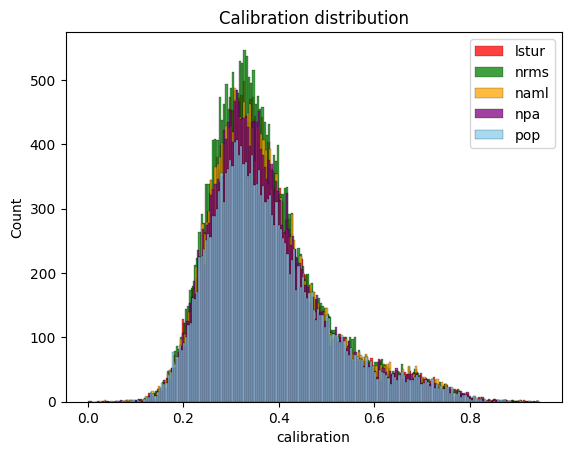

In [32]:
df = df_calibration_all

# Plot the histogram thanks to the histplot function
sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["calibration"]], bins=200, x="calibration", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["calibration"]], bins=200, x="calibration", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["calibration"]], bins=200, x="calibration", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["calibration"]], bins=200, x="calibration", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["calibration"]], bins=200, x="calibration", color="skyblue", label="pop", kde=False)

plt.title("Calibration distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [33]:
calibration_mean_std = df_calibration_all.groupby('algo').agg({'calibration':'mean'}).merge(
                        df_calibration_all.groupby('algo').agg({'calibration':'std'}), on='algo')
calibration_mean_std = calibration_mean_std.rename(columns={'calibration_x':'calibration_mean', 
                                                            'calibration_y':'calibration_std'}).reset_index()
calibration_mean_std

,algo,calibration_mean,calibration_std
0,lstur,0.375128,0.122127
1,naml,0.374850,0.122427
2,npa,0.375374,0.121467
3,nrms,0.372050,0.120015
4,pop,0.377061,0.124307


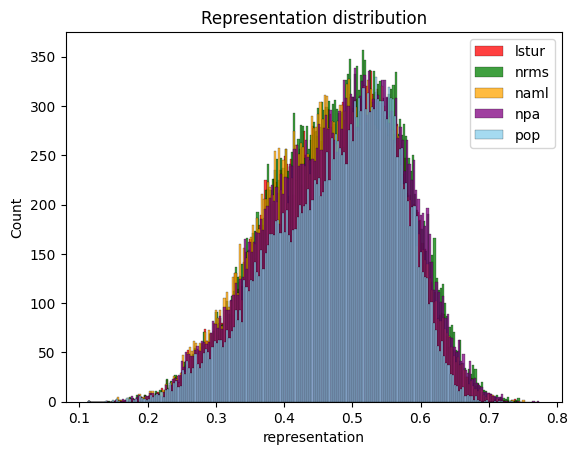

In [34]:
df = df_representation_all

sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["representation"]], bins=200, x="representation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["representation"]], bins=200, x="representation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["representation"]], bins=200, x="representation", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["representation"]], bins=200, x="representation", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["representation"]], bins=200, x="representation", color="skyblue", label="pop", kde=False)

plt.title("Representation distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [35]:
representation_mean_std = df_representation_all.groupby('algo').agg({'representation':'mean'}).merge(
                        df_representation_all.groupby('algo').agg({'representation':'std'}), on='algo')
representation_mean_std = representation_mean_std.rename(columns={'representation_x':'representation_mean', 
                                                            'representation_y':'representation_std'}).reset_index()
representation_mean_std

,algo,representation_mean,representation_std
0,lstur,0.471451,0.095339
1,naml,0.468553,0.096186
2,npa,0.476683,0.097911
3,nrms,0.476347,0.096935
4,pop,0.476303,0.090946


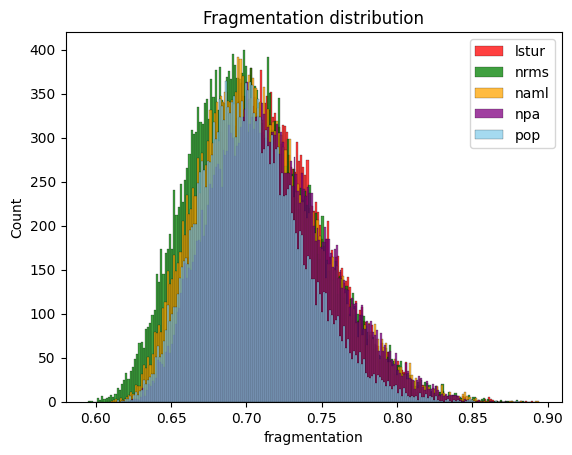

In [36]:
df = df_fragmentation_all
  
sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["fragmentation"]], bins=200, x="fragmentation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["fragmentation"]], bins=200, x="fragmentation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["fragmentation"]], bins=200, x="fragmentation", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["fragmentation"]], bins=200, x="fragmentation", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["fragmentation"]], bins=200, x="fragmentation", color="skyblue", label="pop", kde=False)

plt.title("Fragmentation distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [38]:
fragmentation_mean_std = df_fragmentation_all.groupby('algo').agg({'fragmentation':'mean'}).merge(
                        df_fragmentation_all.groupby('algo').agg({'fragmentation':'std'}), on='algo')
fragmentation_mean_std = fragmentation_mean_std.rename(columns={'fragmentation_x':'fragmentation_mean', 
                                                            'fragmentation_y':'fragmentation_std'}).reset_index()
fragmentation_mean_std

,algo,fragmentation_mean,fragmentation_std
0,lstur,0.715926,0.037943
1,naml,0.709987,0.040486
2,npa,0.716678,0.038862
3,nrms,0.705333,0.042289
4,pop,0.704677,0.034271
